# PyTV-4D: Getting started

## Computing TV and subgradient

Below is a simple example to compute the total variation and sub-gradient on CPU and GPU:

In [4]:
import pytv
import numpy as np

Nz, M, N = 20, 4, 100 # 4D Image dimensions. M is for time.
np.random.seed(0)
img = np.random.rand(Nz, M, N, N)

tv1, G1 = pytv.tv_CPU.tv_hybrid(img)
tv2, G2 = pytv.tv_GPU.tv_hybrid(img)

print('TV value from CPU: '+str(tv1))
print('TV value from GPU: '+str(tv2))
print('Sub-gradients from CPU and GPU are equal: '+str(np.prod(np.abs(G1-G2)<1e-5)>0))

TV value from CPU: 532166.8251801673
TV value from GPU: 532166.8
Sub-gradients from CPU and GPU are equal: True


## Denoizing an image

A simple example of image denoizing using the total variation. The following loss function is minimized:

$$\frac{1}{2} ||x - x_0 ||_2^2 + \lambda \text{TV}(x)$$

where $x$ is the current image, $x_0$ is the input noisy image, and $\lambda$ is a regularization parameter.
Because the TV is not everywhere differentiable, the sub-gradient descent method is used to minimize this loss function:

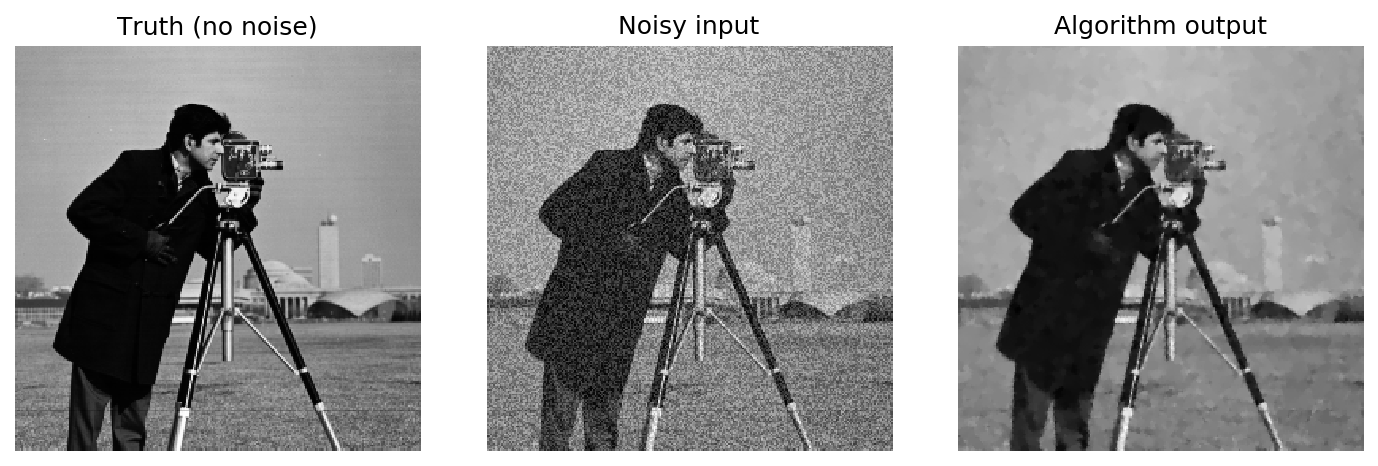

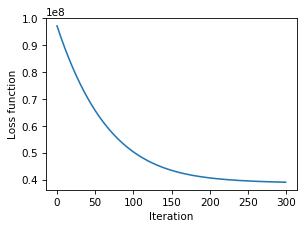

In [8]:
import matplotlib.pyplot as plt

noise_level = 100
nb_it = 300
regularization = 25
step_size = 5e-3 # If step size is too large, loss function may not decrease at every step

np.random.seed(0)
cameraman_truth = pytv.utils.cameraman() # Open the cameraman's grayscale image
cameraman_truth = np.reshape(cameraman_truth, (1,1,)+cameraman_truth.shape)
cameraman_noisy = cameraman_truth + noise_level * np.random.rand(*cameraman_truth.shape) # Add noise
cameraman_estimate = np.copy(cameraman_noisy)

loss_fct_GD = np.zeros([nb_it,])
for it in range(nb_it): # A simple sub-gradient descent algorithm for image denoising
    tv, G = pytv.tv_GPU.tv_hybrid(cameraman_estimate)
    cameraman_estimate += - step_size * ((cameraman_estimate - cameraman_noisy) + regularization * G)
    loss_fct_GD[it] = 0.5 * np.sum(np.square(cameraman_estimate - cameraman_noisy)) + regularization * tv

plt.figure(1, figsize=[9.5, 3], dpi = 150)
plt.subplot(1,3,1, title='Truth (no noise)')
plt.imshow(cameraman_truth.squeeze(), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(1,3,2, title='Noisy input')
plt.axis('off')
plt.imshow(cameraman_noisy.squeeze(), cmap = plt.get_cmap('gray'))
plt.subplot(1,3,3, title='Algorithm output')
plt.imshow(cameraman_estimate.squeeze(), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.tight_layout(pad=0.5)

plt.figure(2, figsize=[4, 3], dpi = 75)
plt.plot(loss_fct_GD)
plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.tight_layout(pad=0.5)
plt.show()


## Accelerated convergence using gradient operators
Because the loss function with total variation is non-smooth, it is challenging the achieve sufficient convergence with the gradient descent algorithm.
Instead, the primal-dual algorithm from Chambolle and Pock (https://doi.org/10.1007/s10851-010-0251-1) achieves faster convergence.
To enable easy implementation of such proximal-based algorithm, the calculations of image gradients are available in PyTV-4D.
A simple example is presented below in the case of the denoising of the cameraman image:

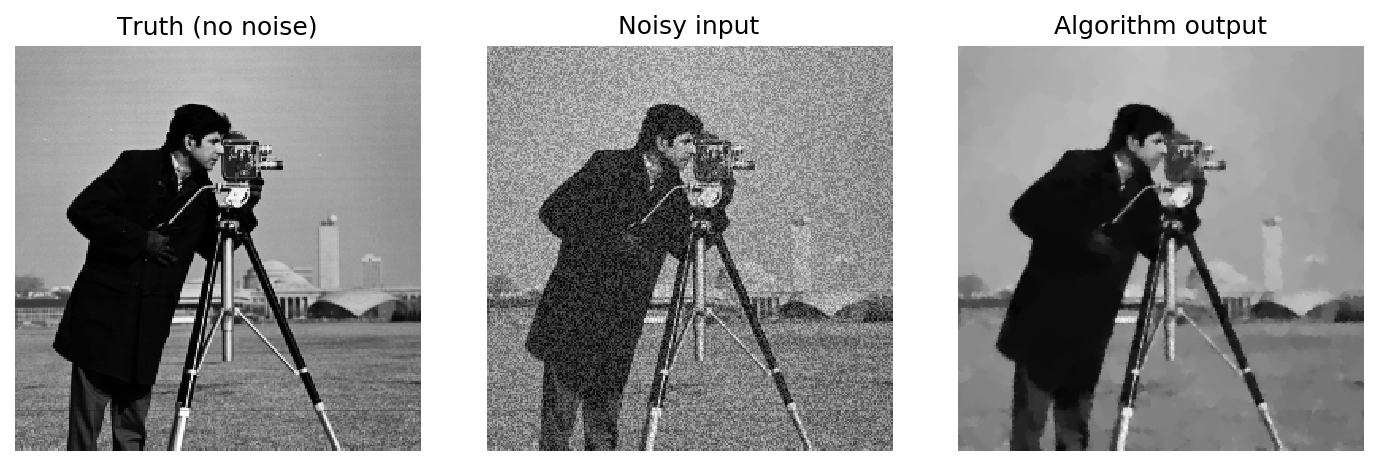

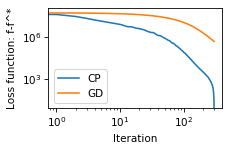

In [9]:
np.random.seed(0)
cameraman_truth = pytv.utils.cameraman() # Open the cameraman's grayscale image
cameraman_truth = np.reshape(cameraman_truth, (1,1,)+cameraman_truth.shape)
cameraman_noisy = cameraman_truth + noise_level * np.random.rand(*cameraman_truth.shape) # Add noise
cameraman_estimate = np.copy(cameraman_noisy)

loss_fct_CP = np.zeros([nb_it,])

primal_update = np.zeros_like(cameraman_noisy)
dual_update_fidelity = np.zeros_like(cameraman_noisy)
dual_update_TV = np.zeros_like(cameraman_noisy)

# A simple version of the Chambolle & Pock algorithm for image denoising
# Ref: Chambolle, Antonin, and Thomas Pock. "A first-order primal-dual algorithm for convex problems with applications to imaging." Journal of mathematical imaging and vision 40.1 (2011): 120-145.
sigma_D = 0.5
sigma_A = 1.0
tau = 1 / (8 + 1)

for it in range(nb_it):

    # Dual update
    dual_update_fidelity = (dual_update_fidelity + sigma_A * (cameraman_estimate - cameraman_noisy))/(1.0+sigma_A)
    D_x = pytv.tv_operators_GPU.D_hybrid(cameraman_estimate)
    prox_argument = dual_update_TV + sigma_D * D_x
    dual_update_TV = prox_argument / np.maximum(1.0, np.sqrt(np.sum(prox_argument**2, axis = 1)) / regularization)

    # Primal update
    cameraman_estimate = cameraman_estimate - tau * dual_update_fidelity - tau * pytv.tv_operators_GPU.D_T_hybrid(dual_update_TV)

    # Loss function update
    loss_fct_CP[it] = 0.5 * np.sum(np.square(cameraman_estimate - cameraman_noisy)) + regularization * pytv.tv_operators_GPU.compute_L21_norm(D_x)

plt.figure(1, figsize=[9.5, 3], dpi = 150)
plt.subplot(1,3,1, title='Truth (no noise)')
plt.imshow(cameraman_truth.squeeze(), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(1,3,2, title='Noisy input')
plt.axis('off')
plt.imshow(np.squeeze(cameraman_noisy.squeeze()), cmap = plt.get_cmap('gray'))
plt.subplot(1,3,3, title='Algorithm output')
plt.imshow(np.squeeze(cameraman_estimate.squeeze()), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.tight_layout(pad=0.5)

loss_fct_min = min(loss_fct_CP.min(), loss_fct_GD.min()) # Achieved with 1000 iterations
plt.figure(2, figsize=[3, 2], dpi = 75)
plt.loglog(loss_fct_CP-loss_fct_min, label = 'CP')
plt.loglog(loss_fct_GD-loss_fct_min, label = 'GD')
plt.xlabel('Iteration')
plt.ylabel('Loss function: f-f^*')
plt.tight_layout(pad=0.5)
plt.legend()
plt.show()

## Different TV discretization

PyTV-4D provides four different discretizations of the spatial and time gradients used to computed the TV (upwind, downwind, central, and hybrid). Functions provide the (sub)-gradient descent algorithms using CPU and GPU:

In [10]:
use_GPU = True

import numpy as np
if use_GPU:
    import pytv.tv_GPU as tv
else:
    import pytv.tv_CPU as tv

Nz, M, N = 20, 4, 100 # 4D Image dimensions. M is for time.
np.random.seed(0)
img = np.random.rand(Nz, M, N, N)

# TV values, and sub-gradient arrays
tv1, G1 = tv.tv_upwind(img)
tv2, G2 = tv.tv_downwind(img)
tv3, G3 = tv.tv_central(img)
tv4, G4 = tv.tv_hybrid(img)


PyTV-4D also provides directly the CPU and GPU operators, useful for proximal algorithms:


In [1]:
use_GPU = True

import numpy as np
if use_GPU:
    import pytv.tv_operators_GPU as tv
else:
    import pytv.tv_operators_CPU as tv

Nz, N = 10, 100 # Image size
M = 2 # Time size
reg_time = 2**(-5) # Time regularization (lambda_t)
img = np.random.rand(Nz, M, N, N)

# Discrete gradient: D_img has size (Nz, Nd, M, N, N) where Nd is the number of difference terms
D_img1 = tv.D_upwind(img, reg_time = reg_time)
D_img2 = tv.D_downwind(img, reg_time = reg_time)
D_img3 = tv.D_central(img, reg_time = reg_time)
D_img4 = tv.D_hybrid(img, reg_time = reg_time)

# Transposed discrete gradient: D_T_D_img has size (Nz, M, N, N)
D_T_D_img1 = tv.D_T_upwind(D_img1, reg_time = reg_time)
D_T_D_img2 = tv.D_T_downwind(D_img2, reg_time = reg_time)
D_T_D_img3 = tv.D_T_central(D_img3, reg_time = reg_time)
D_T_D_img4 = tv.D_T_hybrid(D_img4, reg_time = reg_time)

# TV values: obtained by computing the L2,1 norm of the image gradient D(img)
tv1 = tv.compute_L21_norm(D_img1)
tv2 = tv.compute_L21_norm(D_img2)
tv3 = tv.compute_L21_norm(D_img3)
tv4 = tv.compute_L21_norm(D_img4)
